# Small Area Income and Poverty Estimates (SAIPE)

By [Christine Zhang](mailto:czhang@baltsun.com)

## Data cleaning and analysis

### Import R data analysis libraries

In [1]:
suppressMessages(library('tidyverse'))
suppressMessages(library('readxl'))
suppressMessages(library('janitor'))
suppressMessages(library('forcats'))

### Read in Small Area Income and Poverty Estimates (SAIPE) data for 2017 and 2016

The 2017 and 2016 data files are available on the U.S. Census Bureau website [here](https://www.census.gov/data/datasets/2017/demo/saipe/2017-state-and-county.html) and [here](https://www.census.gov/data/datasets/2016/demo/saipe/2016-state-and-county.html), respectively.

In [2]:
saipe.17 <- read_excel('input/est17all.xls', skip = 3) %>% clean_names()
saipe.16 <- read_excel('input/est16all.xls', skip = 3) %>% clean_names()

### Clean up and subset the dataframes to include only the columns of interest

In [3]:
glimpse(saipe.17)

Observations: 3,194
Variables: 31
$ state_fips_code                       <chr> "00", "01", "01", "01", "01",...
$ county_fips_code                      <chr> "000", "000", "001", "003", "...
$ postal_code                           <chr> "US", "AL", "AL", "AL", "AL",...
$ name                                  <chr> "United States", "Alabama", "...
$ poverty_estimate_all_ages             <chr> "42583651", "802263", "7390",...
$ x90_percent_ci_lower_bound            <chr> "42342619", "784517", "6147",...
$ x90_percent_ci_upper_bound            <chr> "42824683", "820009", "8633",...
$ poverty_percent_all_ages              <chr> "13.4", "16.899999999999999",...
$ x90_percent_ci_lower_bound_1          <chr> "13.300000000000001", "16.5",...
$ x90_percent_ci_upper_bound_1          <chr> "13.5", "17.300000000000001",...
$ poverty_estimate_age_0_17             <chr> "13353202", "262909", "2542",...
$ x90_percent_ci_lower_bound_2          <chr> "13229339", "253694", "2081",...
$ x90_percent_ci_u

Write a function to convert character columns to numeric, select the columns of interest and calculate the standard errors of the poverty rates.

In [4]:
cleanup <- function (df) {
    
    df <- df %>% mutate(pov_perc = as.numeric(poverty_percent_all_ages),
                        pov_perc_moe = pov_perc - as.numeric(x90_percent_ci_lower_bound_1),
                        pov_perc_se =  pov_perc_moe/1.645) %>%
                 select(state_fips_code, 
                        county_fips_code, 
                        name,
                        pov_perc,
                        pov_perc_se)
    
    return(df)
    
    }

In [5]:
saipe.17.clean <- cleanup(saipe.17)
saipe.16.clean <- cleanup(saipe.16)

Warning message in evalq(as.numeric(poverty_percent_all_ages), <environment>):
“NAs introduced by coercion”Warning message in evalq(pov_perc - as.numeric(x90_percent_ci_lower_bound_1), <environment>):
“NAs introduced by coercion”Warning message in evalq(as.numeric(poverty_percent_all_ages), <environment>):
“NAs introduced by coercion”Warning message in evalq(pov_perc - as.numeric(x90_percent_ci_lower_bound_1), <environment>):
“NAs introduced by coercion”

### "According to the SAIPE statistics, which use other sources in addition to the ACS to calculate yearly rates, U.S. poverty dropped from 14 percent to 13.4 percent between 2016 and 2017."

Merge `saipe.17.clean`  with `saipe.16.clean` to create `saipe.merged`.

In [6]:
saipe.merged <- merge(saipe.17.clean, saipe.16.clean, by = c('state_fips_code',
                                                              'county_fips_code',
                                                              'name'), 
                     suffixes = c('_2017', '_2016'))

Filter `saipe.merged` to view the United States.

In [7]:
saipe.merged %>% filter(name == 'United States')

state_fips_code,county_fips_code,name,pov_perc_2017,pov_perc_se_2017,pov_perc_2016,pov_perc_se_2016
00,000,United States,13.4,0.06079027,14,0.06079027


Print out the poverty rates.

In [8]:
print(paste('U.S. poverty dropped from', saipe.merged[saipe.merged$name == 'United States',]$pov_perc_2016, 
            'percent to', saipe.merged[saipe.merged$name == 'United States',]$pov_perc_2017, 'percent between 2016 and 2017.'))

[1] "U.S. poverty dropped from 14 percent to 13.4 percent between 2016 and 2017."


Check if the difference is significant at the 90 percent confidence level. See ["Understanding and Using American Community Survey Data: What All Data Users Need to Know"](https://www.census.gov/programs-surveys/acs/guidance/handbooks/general.html) (starting from page 44) for more information.

In [9]:
saipe.merged <- saipe.merged %>% mutate(pov_diff = pov_perc_2017 - pov_perc_2016,
                                        se_diff = sqrt(pov_perc_se_2017^2 + pov_perc_se_2016^2),
                                        t_diff = pov_diff/se_diff,
                                        signif = ifelse(abs(t_diff) > 1.645, 1, 0))

The absolute value of `t_diff` is greater than 1.645 indicating significance at the 90 percent confidence level.

In [10]:
saipe.merged %>% filter(name == 'United States') 

state_fips_code,county_fips_code,name,pov_perc_2017,pov_perc_se_2017,pov_perc_2016,pov_perc_se_2016,pov_diff,se_diff,t_diff,signif
00,000,United States,13.4,0.06079027,14,0.06079027,-0.6,0.08597043,-6.979144,1


### "In Maryland, SAIPE estimates that 9.4 percent of residents lived in poverty in 2017 — a rate that was unchanged from 2016, after accounting for margins of error."

Filter `saipe.merged` to view Maryland.

In [11]:
saipe.merged %>% filter(name == 'Maryland')

state_fips_code,county_fips_code,name,pov_perc_2017,pov_perc_se_2017,pov_perc_2016,pov_perc_se_2016,pov_diff,se_diff,t_diff,signif
24,000,Maryland,9.4,0.1823708,9.7,0.1215805,-0.3,0.2191824,-1.368723,0


The absolute value of `t_diff` is less than 1.645, indicating Maryland's change in poverty rate between 2016 and 2017 is not significant at the 90 percent confidence level.

## Data visualization

In [12]:
md <- saipe.merged %>% filter(state_fips_code == '24') %>% 
                       mutate(name.factor = fct_reorder(name, pov_perc_2017))

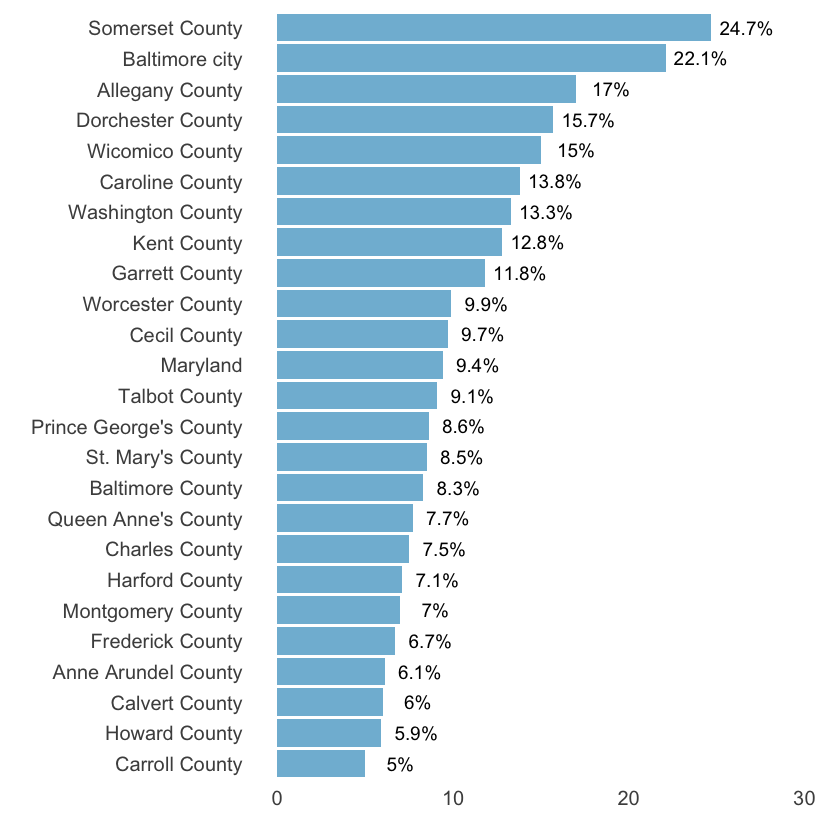

In [13]:
p <- ggplot(md, aes(x = name.factor, y = pov_perc_2017)) +
                geom_bar(stat = 'identity', fill = '#80BAD7') +
                coord_flip() +
                labs(x = '', y = '') + 
                scale_y_continuous(limits = c(0, 30)) +
                geom_text(aes(y = pov_perc_2017 + 2, 
                              label = paste0(pov_perc_2017, '%')), 
                          position = position_dodge(width = .9), 
                          size = 4)


p.save <- p + theme(panel.grid.minor.x = element_blank(), 
          axis.ticks = element_blank(),
          axis.text = element_text(size = 12),
          panel.background = element_blank(),
          legend.title = element_blank())

print(p.save)

# save a version for Illustrator
ggsave("output/saipe_poverty_17.eps", p.save,
       device = 'eps', width = 8, height = 6)